## All imports

In [56]:
%matplotlib inline
import numpy as np
np.random.seed(123)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
#from IPython.display import display 
#from PIL import Image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import time


## Define all constants

In [57]:
TRAIN_DIR = "cbis-ddsm/patches/calcification/train"
TEST_DIR = "cbis-ddsm/patches/calcification/test"
IM_WIDTH, IM_HEIGHT = 256, 256
FC_SIZE = 256
batch_size = 75
NUM_CLASSES = 4
NUM_EPOCHS = 10

## Train & Test Generator

In [58]:
train_datagen = ImageDataGenerator(
                preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
  )

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
)

Found 290202 images belonging to 4 classes.
Found 59634 images belonging to 4 classes.


## Model

In [6]:
base_model = InceptionV3(weights=None, include_top=False)

In [7]:
def add_new_last_layer(base_model, nb_classes):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) 
    predictions = Dense(nb_classes, activation='softmax')(x) 
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [8]:
model = add_new_last_layer(base_model,NUM_CLASSES)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


start = time.time()
modelFit = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples/batch_size,
            epochs=NUM_EPOCHS,
            verbose = 1,
            validation_data=test_generator,
            validation_steps=test_generator.samples/batch_size)
end = time.time()

total_time = int(end-start)
time_per_epoch = total_time/NUM_EPOCHS

forecasted_time = 100000 * time_per_epoch / (train_generator.samples + test_generator.samples)
print ()
print ()
print ("Model took " + str(total_time) + " seconds to run" )
print ("Model takes " + str(time_per_epoch) + " seconds to run")
print ("Approximate time taken per epoch for 100,000 images is " + str(forecasted_time) + " seconds")

Epoch 1/10
3870/3869 [==============================] - 14890s - loss: 1.0937 - acc: 0.5280 - val_loss: 1.1399 - val_acc: 0.4844
Epoch 2/10
3870/3869 [==============================] - 14385s - loss: 1.0170 - acc: 0.5501 - val_loss: 1.0450 - val_acc: 0.5302
Epoch 3/10
3870/3869 [==============================] - 14213s - loss: 0.9723 - acc: 0.5676 - val_loss: 1.0243 - val_acc: 0.5338
Epoch 4/10
3870/3869 [==============================] - 14553s - loss: 0.9324 - acc: 0.5850 - val_loss: 1.0630 - val_acc: 0.5317
Epoch 5/10
3870/3869 [==============================] - 14191s - loss: 0.8904 - acc: 0.6039 - val_loss: 1.0817 - val_acc: 0.5427
Epoch 6/10
3870/3869 [==============================] - 14156s - loss: 0.8526 - acc: 0.6207 - val_loss: 1.0241 - val_acc: 0.5450
Epoch 7/10
3870/3869 [==============================] - 14099s - loss: 0.8193 - acc: 0.6370 - val_loss: 1.0729 - val_acc: 0.5439
Epoch 8/10
3870/3869 [==============================] - 13811s - loss: 0.7869 - acc: 0.6554 - val

## Model will take more than 1 hour 10 minutes for 1 epoch when run on 100k images

In [9]:
model.count_params()

22328356

In [15]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    #print (trainable_count)
    return gbytes,trainable_count

In [16]:
(memory, count) = get_model_memory_usage(NUM_EPOCHS,model)

print ("Memory usage in GB is", memory )
print ("Trainable parameters count is", count )

Memory usage in GB is 0.835
Trainable parameters count is 22293924


In [11]:
model.save("GoogleNetNotPretrained256Patches.h5")

In [12]:
%matplotlib inline
def plot_model_history(history):
    training_accuracy = history.history['acc']
    validation_accuracy = history.history['val_acc']
    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.title('Model Accuracy')
    plt.plot(training_accuracy)
    plt.plot(validation_accuracy)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(2,1,2)
    plt.title('Model Loss')
    plt.plot(training_loss)
    plt.plot(validation_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.show()
    

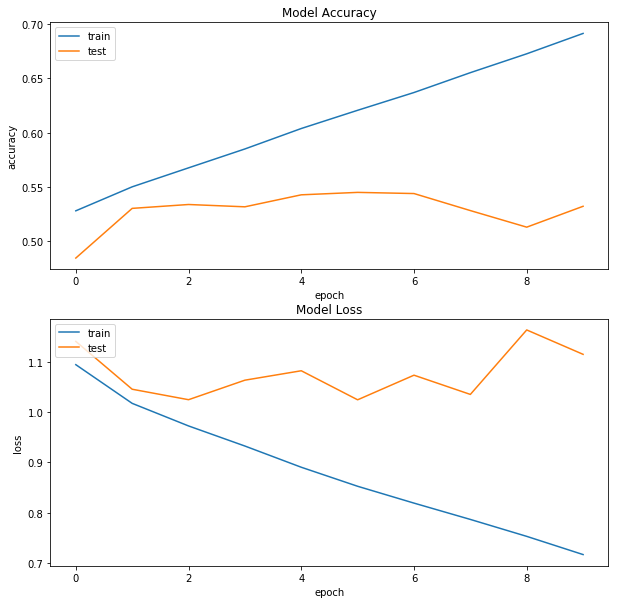

In [13]:
plot_model_history(modelFit)



In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [1]:
from keras.models import load_model

model = load_model('GoogleNetNotPretrained256Patches.h5')

Using TensorFlow backend.


In [2]:
HOME = '/home/agunapal'


In [49]:
test_file = HOME + "/data/cbis-ddsm/patches/temp/full/Calc-Test_P_00857_RIGHT_MLO"

In [53]:
img = cv2.imread(test_file)

In [35]:
img

In [40]:
img.shape

(4552, 3160, 3)

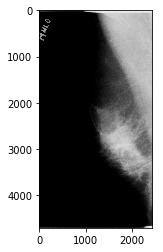

In [51]:
plt.imshow(img)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


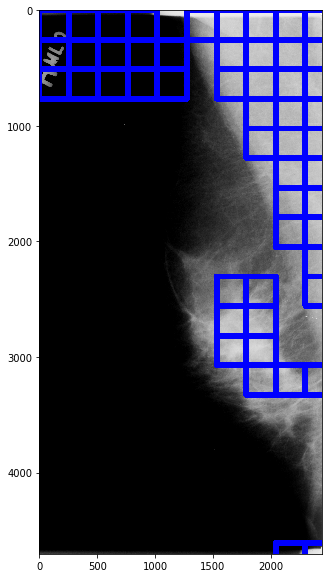

In [54]:
WIDTH = HEIGHT = 256

blue = (0,0,255)
red = (255,0,0)
green = (0,255,0)

color = {0:blue,2:red,1:green}

i = 0
plt.figure(figsize=(20,10))
for height in range(0, img.shape[0], HEIGHT):
    for width in range(0,img.shape[1],WIDTH):
        i += 1
        row = img.shape[0]/HEIGHT 
        col = img.shape[1]/WIDTH
        crop = np.expand_dims(img[height:height+HEIGHT, width:width+WIDTH,:], axis=0)
        
        #print (np.mean(crop))
        if np.mean(crop) > 10:
            #print (i)
            classes = model.predict(crop)
            if classes.argmax(axis=-1).item(0) == 3:
                continue
            #print (np.max(classes))
            print (classes.argmax(axis=-1).item(0))
            cv2.rectangle(img,(width,height), ( width+WIDTH, height +HEIGHT), color[classes.argmax(axis=-1).item(0)],50)
            
            #print (color[classes.argmax(axis=-1).item(0)])
            #print (width,height)
                              
            
plt.imshow(img)                              
                              

In [14]:
temp = np.expand_dims(img, axis=0)

In [59]:
print (train_generator.class_indices)

{'benign': 0, 'benign_no_callback': 1, 'malignant': 2, 'no_tumor': 3}


In [60]:
print (test_generator.class_indices)

{'benign': 0, 'benign_no_callback': 1, 'malignant': 2, 'no_tumor': 3}


In [15]:
y_proba = model.predict(temp)
y_proba.argmax(axis=-1)

array([0])

In [64]:
y_classes

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])